<a href="https://colab.research.google.com/github/jiuuu26/Dacon_bird-image-classification/blob/main/dacon_efficientnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd '/content/drive/MyDrive/ dacon_bird_classification'

/content/drive/MyDrive/ dacon_bird_classification


In [ ]:
!git clone https://github.com/lukemelas/EfficientNet-PyTorch
!cd EfficientNet-Pytorch
!pip install efficientnet_pytorch   # 왜 -e . 작동 x?

fatal: destination path 'EfficientNet-PyTorch' already exists and is not an empty directory.
/bin/bash: line 1: cd: EfficientNet-Pytorch: No such file or directory
  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1

In [ ]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=25)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 32.6MB/s]

Loaded pretrained weights for efficientnet-b0


In [ ]:
!unzip -qq "/content/drive/MyDrive/ dacon_bird_classification/dataset.zip" -d "/content/drive/MyDrive/ dacon_bird_classification/"

replace /content/drive/MyDrive/ dacon_bird_classification/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import random
import os
import re
import glob
import cv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore')

In [ ]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [ ]:
print(f'train size: {train.shape}')
print(f'test size: {test.shape}')

train size: (15834, 3)
test size: (6786, 2)


In [ ]:
train.head()

,img_path,upscale_img_path,label
0,./train/TRAIN_00000.jpg,./upscale_train/TRAIN_00000.png,Ruddy Shelduck
1,./train/TRAIN_00001.jpg,./upscale_train/TRAIN_00001.png,Gray Wagtail
2,./train/TRAIN_00002.jpg,./upscale_train/TRAIN_00002.png,Indian Peacock
3,./train/TRAIN_00003.jpg,./upscale_train/TRAIN_00003.png,Common Kingfisher
4,./train/TRAIN_00004.jpg,./upscale_train/TRAIN_00004.png,Common Kingfisher


In [ ]:
test.head()

,id,img_path
0,TEST_00000,./test/TEST_00000.jpg
1,TEST_00001,./test/TEST_00001.jpg
2,TEST_00002,./test/TEST_00002.jpg
3,TEST_00003,./test/TEST_00003.jpg
4,TEST_00004,./test/TEST_00004.jpg


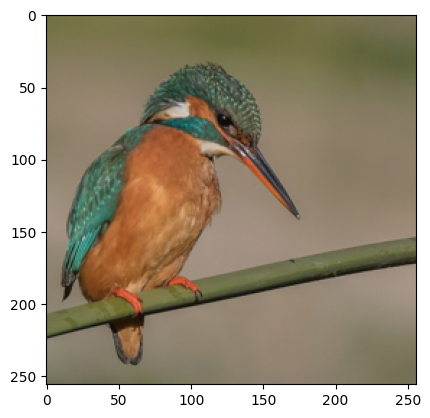

In [ ]:
image=Image.open(train.iloc[14511,1])
plt.imshow(image)
plt.show()

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')


In [ ]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':10,
    'LEARNING_RATE':3e-4,
    'BATCH_SIZE':32,
    'SEED':41
}

In [ ]:
df = train
# 사이에 전처리 진행하기
df =  df.sample(frac=0.5, random_state=42)

In [ ]:
X = df.drop('label', axis=1)
y = df['label']

In [ ]:
X.shape

(7917, 2)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=CFG['SEED'])

In [ ]:
label_encoding=preprocessing.LabelEncoder()
y_train=label_encoding.fit_transform(y_train)
y_valid=label_encoding.transform(y_valid)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms

    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        image = cv2.imread(img_path)

        if self.transforms is not None:
            image = self.transforms(image=image)['image']

        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image

    def __len__(self):
        return len(self.img_path_list)

In [ ]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

val_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [ ]:
train_dataset = CustomDataset(X_train.iloc[:,0].values, y_train, train_transform)
val_dataset = CustomDataset(X_valid.iloc[:,0].values, y_valid, val_transform)

In [ ]:
train_loader = DataLoader(
    train_dataset,
    batch_size = CFG['BATCH_SIZE'],
    shuffle=True,
    num_workers=0
)
val_loader = DataLoader(
    val_dataset,
    batch_size=CFG['BATCH_SIZE'],
    shuffle=False,
    num_workers=0
)

In [ ]:
class BaseModel(nn.Module):
  def __init__(self, num_classes=len(label_encoding.classes_)):
    super(BaseModel, self).__init__()
    self.backbone = models.efficientnet_b0(pretrained=True)
    self.classifier = nn.Linear(1000, num_classes)

  def forward(self, x):
    x = self.backbone(x)
    x = self.classifier(x)
    return x

In [ ]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
  model.to(device)
  criterion = nn.CrossEntropyLoss().to(device)

  best_score = 0
  best_model = None

  for epoch in range(1, CFG['EPOCHS']+1):
    model.train()
    train_loss = []
    for imgs, labels in tqdm(iter(train_loader)):
      imgs = imgs.float().to(device)
      labels = labels.to(device)

      optimizer.zero_grad()

      output = model(imgs)
      loss = criterion(output, labels)

      loss.backward()
      optimizer.step()

      train_loss.append(loss.item())

    val_loss, val_score = validation(model, criterion, val_loader, device)
    train_loss = np.mean(train_loss)
    print(f'Epoch [{epoch}], Train Loss : [{np.mean(train_loss):.5f}] Val Loss : [{val_loss:.5f}] Val F1 Score : [{val_score:.5f}]')

    if scheduler is not None:
      scheduler.step(val_score)

    if best_score < val_score:
      best_score = val_score
      best_model = model

    return best_model

In [ ]:
def validation(model, criterion, val_loader, device):
  model.eval()
  val_loss = []
  preds, true_labels = [], []

  with torch.no_grad():
      for imgs, labels in tqdm(iter(val_loader)):
          imgs = imgs.float().to(device)
          labels = labels.to(device)

          pred = model(imgs)

          loss = criterion(pred, labels)

          preds += pred.argmax(1).detach().cpu().numpy().tolist()
          true_labels += labels.detach().cpu().numpy().tolist()

          val_loss.append(loss.item())

      val_loss = np.mean(val_loss)
      val_score = f1_score(true_labels, preds, average='weighted')

  return val_loss, val_score

In [ ]:
model = BaseModel()
model.eval()
optimizer = torch.optim.Adam(params = model.parameters(), lr = CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=10, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/198 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1], Train Loss : [1.34069] Val Loss : [0.61119] Val F1 Score : [0.80618]


##Test

In [ ]:
test = pd.read_csv('./test.csv')

In [ ]:
test_dataset = CustomDataset(test['img_path'].values, None, test_transform)
test_loader = DataLoader(test_dataset, batch_size=CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [ ]:
def inference(model, test_loader, device):
    model.eval()
    preds = []
    with torch.no_grad():
        for imgs in tqdm(iter(test_loader)):
            imgs = imgs.float().to(device)

            pred = model(imgs)

            preds += pred.argmax(1).detach().cpu().numpy().tolist()

    preds = le.inverse_transform(preds)
    return preds

In [ ]:
preds = inference(infer_model, test_loader, device)

##Submission

In [ ]:
submit = pd.read_csv('./sample_submission.csv')

In [ ]:
submit['label'] = preds

In [ ]:
submit.to_csv('./baseline_submit.csv', index=False)